In [47]:
#Importamos todas las librerias que vamos a usar para el desarollo del trabajo

import pandas as pd
import gc
from sklearn.impute import SimpleImputer
from xgboost import XGBClassifier 
import xgboost as xgb
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
import numpy as np 
import time
import sklearn
from sklearn.metrics import balanced_accuracy_score, roc_auc_score, make_scorer
from sklearn.model_selection import ParameterSampler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
import re
import logging
import gensim
import numpy as np
import random
import os
import pickle
import tqdm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
import nltk
import matplotlib.pyplot as plt
from scipy.stats import uniform
import pandas as pd
import gc
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier
import seaborn as sns
import matplotlib.pyplot as plt


## Creación del primer subbmit y primer análisis del dataset 

In [48]:
data = pd.read_csv("/Users/franciscofrustoalvarado/Desktop/TD_VI/TP2_TDVI/competition_data.csv")

# Split into training and evaluation samples
train_data = data[data["ROW_ID"].isna()]
eval_data = data[data["ROW_ID"].notna()]
gc.collect()

# Train a tree on the train data
train_data = train_data.sample(frac=1/3)
y_train = train_data["conversion"]
X_train = train_data.drop(columns=["conversion", "ROW_ID"])
X_train = X_train.select_dtypes(include='number')
del train_data
gc.collect()

cls = make_pipeline(SimpleImputer(), DecisionTreeClassifier(max_depth=8, random_state=2345))
cls.fit(X_train, y_train)

# Predict on the evaluation set
y_true = eval_data["conversion"]
eval_data = eval_data.drop(columns=["conversion"])
eval_data = eval_data.select_dtypes(include='number')
y_preds = cls.predict_proba(eval_data.drop(columns=["ROW_ID"]))[:, cls.classes_ == 1].squeeze()


# Make the submission file
submission_df = pd.DataFrame({"ROW_ID": eval_data["ROW_ID"], "conversion": y_preds})
submission_df["ROW_ID"] = submission_df["ROW_ID"].astype(int)
submission_df.to_csv("basic_model.csv", sep=",", index=False)

In [43]:
# Asumiendo que 'importances' contiene la importancia de cada atributo
importances = cls.named_steps['decisiontreeclassifier'].feature_importances_

# Obtener los índices de los atributos en orden descendente de importancia
sorted_indices = np.argsort(importances)[::-1]

# Obtener los nombres de los atributos correspondientes a los 20 primeros índices
top_20_attributes = X_train.columns[sorted_indices[:20]]

# Obtener las importancias correspondientes a los 20 atributos
top_20_importances = importances[sorted_indices[:20]]

# Imprimir los nombres y las importancias de los 20 atributos más importantes
for attribute, importance in zip(top_20_attributes, top_20_importances):
    print(f'{attribute}: {importance.round(5)}')

print_position: 0.3941
user_id: 0.10544
total_orders_item_30days: 0.07388
offset: 0.04267
available_quantity: 0.03991
total_visits_item: 0.03482
product_id: 0.02939
avg_gmv_item_sel: 0.02708
avg_qty_orders_item_domain_30days: 0.0241
sold_quantity: 0.02271
avg_gmv_seller_bday: 0.02203
avg_gmv_item_domain_30days: 0.02044
total_visits_seller: 0.01558
avg_si_item_sel_30day: 0.01465
total_items_seller: 0.01452
avg_qty_orders_item_sel_30days: 0.01372
total_si_sel_30days: 0.01144
price: 0.01092
total_asp_item_domain_30days: 0.01049
total_si_item_30days: 0.01011


## Creacion de los gráficos

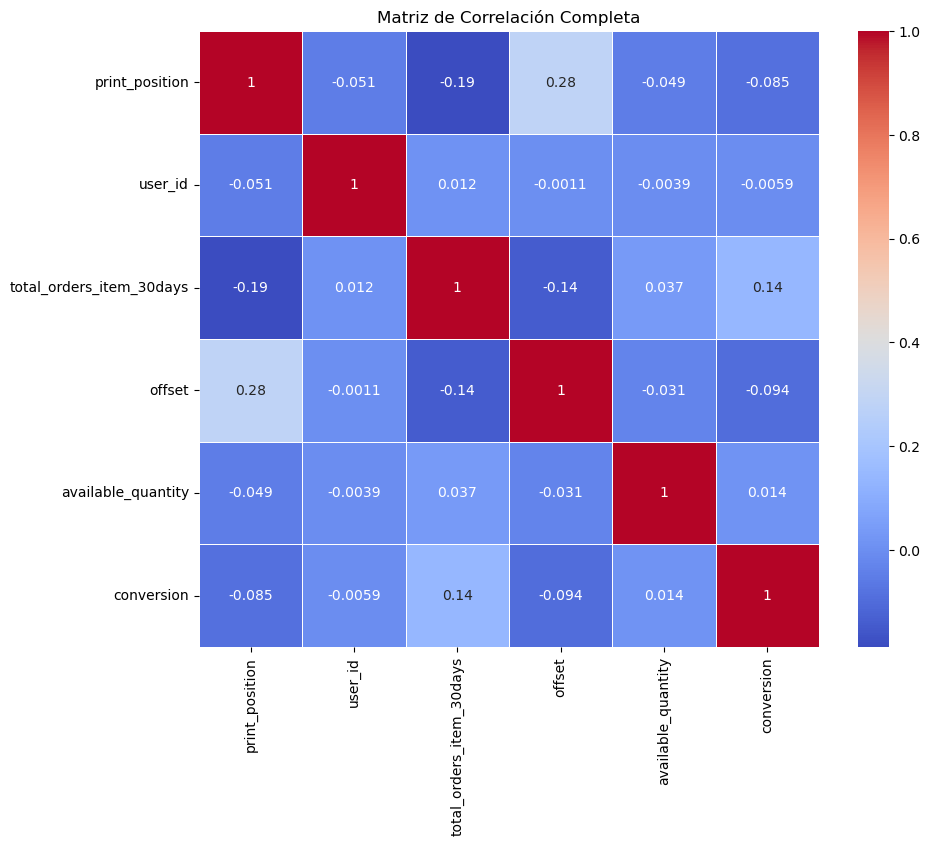

In [65]:
# Selecciona solo las columnas de interés
columnas_seleccionadas = ['print_position','user_id','total_orders_item_30days','offset','available_quantity', 'conversion']
data_seleccionada = data[columnas_seleccionadas]

# Calcula la matriz de correlación para las columnas seleccionadas
matriz_correlacion_seleccionada = data_seleccionada.corr()

# Crea un mapa de calor para la matriz de correlación completa
plt.figure(figsize=(10, 8))
sns.heatmap(data_seleccionada.corr(), annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Matriz de Correlación Completa')
plt.show()

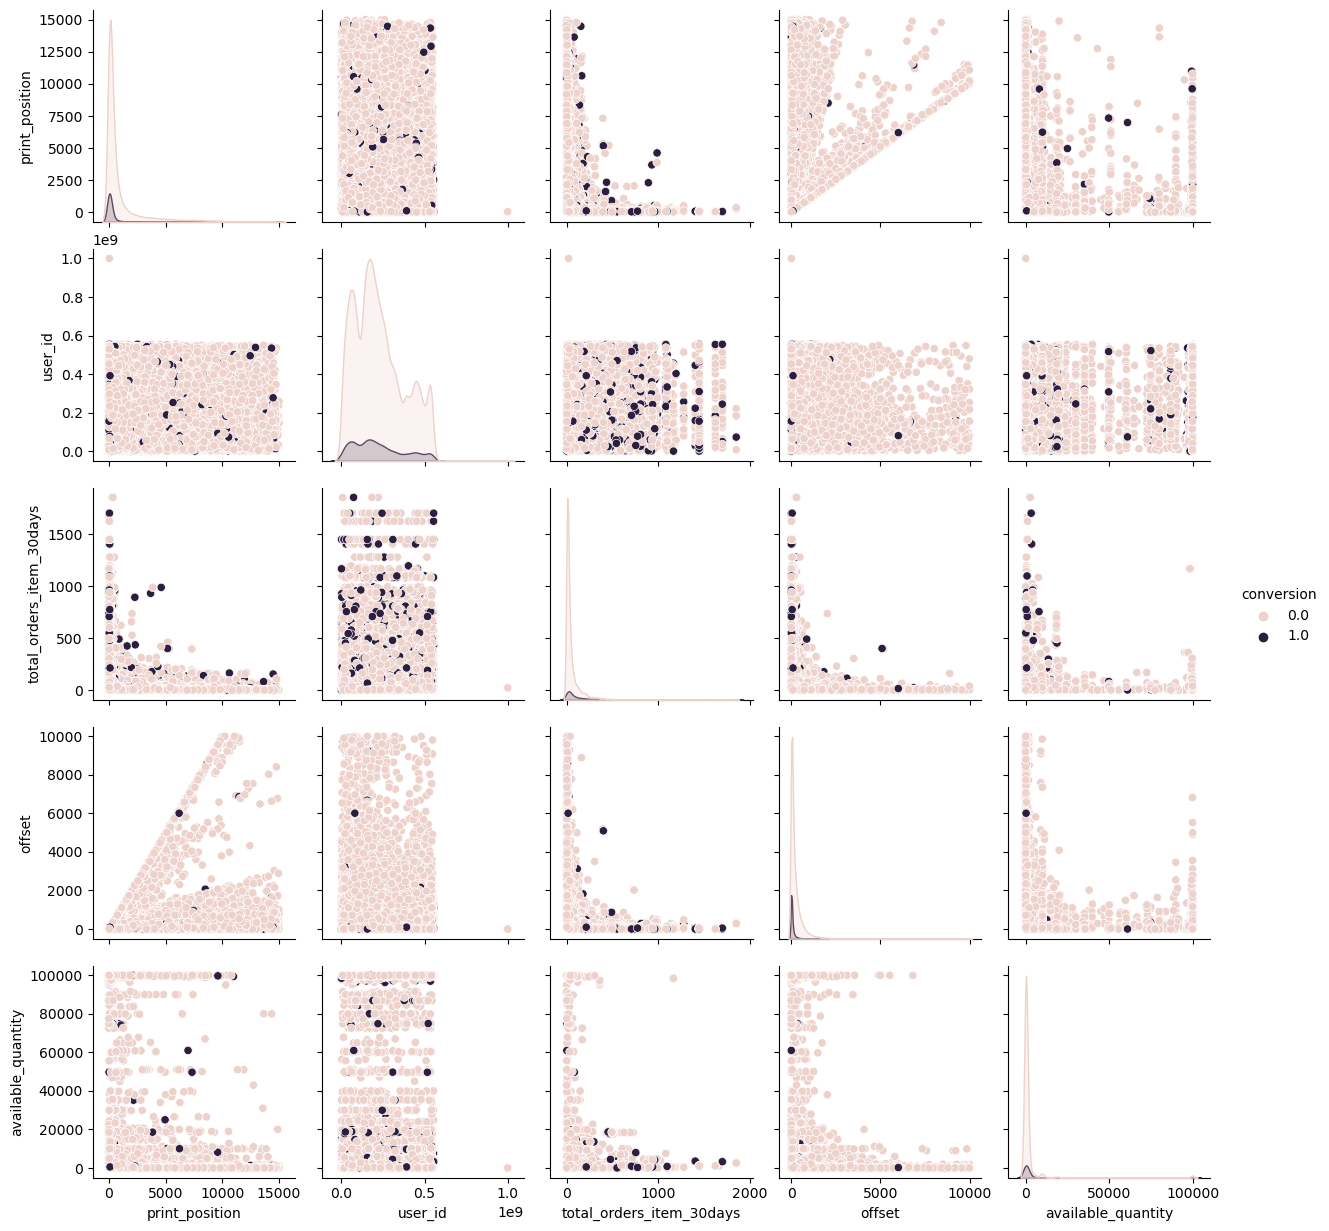

In [64]:


# # Crea un mapa de calor para la matriz de correlación de las columnas seleccionadas
# plt.figure(figsize=(8, 6))
# sns.heatmap(matriz_correlacion_seleccionada, annot=True, cmap='coolwarm', linewidths=0.5)
# plt.title('Matriz de Correlación de Columnas Seleccionadas')
# plt.show()

# Selecciona solo algunos atributos del DataFrame 'data'
atributos_seleccionados = ['print_position','user_id','total_orders_item_30days','offset','available_quantity', 'conversion']
data_seleccionada = data[atributos_seleccionados]

# Crea un pair plot directamente desde el DataFrame de pandas
sns.pairplot(data_seleccionada, hue= 'conversion')

# Mostrar el gráfico
plt.show()

## Modelo xgboost_model_20.csv

El desarrollo de este modelo, fue un trabajo iterativo en el que para lograr el modelo final, previamente se entrenaron muchos y distintos modelos donde se fue mejorando cada uno y este modelo final es el resultado de la suma de todas las mejoras. 
Este modelo, entrena en base a 115 atributos que incluyen, nuevas variables creadas, Word2vec de los titulos de cada publicacion y one hot encoding de algunas variables categoricas. Una pequeña obervación, es que al intentar probar hacer OHE con los metodos más eficientes y fáciles, tuvimos muchos errores para poder correrlo, de manera que terminamos haciendolo de una manera más "manual". 

In [30]:
# Abrimos el dataset y realizamos las modificaciones

comp_data = pd.read_csv("/Users/franciscofrustoalvarado/Desktop/TD_VI/TP2_TDVI/competition_data.csv")

# Paso la fecha a variable dia, mes, año 
comp_data["date"] = pd.to_datetime(comp_data["date"])
comp_data['day'] = comp_data['date'].dt.day
comp_data['month'] = comp_data['date'].dt.month
comp_data['year'] = comp_data['date'].dt.year
comp_data.drop(columns=["date"])

#Cambio el listing_type_id por 1 y 2
for fila in comp_data['listing_type_id'].index:
    if comp_data['listing_type_id'][fila] == 'gold_special':
        comp_data['listing_type_id'][fila] = 1
    elif comp_data['listing_type_id'][fila] == 'gold_pro':
        comp_data['listing_type_id'][fila] = 2

#Creo una variable que cuenta la cantidad de tags que tiene cada producto
comp_data['tags_count'] = comp_data['tags'].str.count(',')+1

#One-hot-enconding
categorical_columns_to_encode = ["accepts_mercadopago", "boosted", "free_shipping", "fulfillment", "is_pdp", "warranty"]

for col in categorical_columns_to_encode:
    # Crear columnas para "True", "False" y "NA"
    comp_data[col + '_true'] = (comp_data[col] == True).astype(int)
    comp_data[col + '_false'] = (comp_data[col] == False).astype(int)
    comp_data[col + '_NA'] = comp_data[col].isna().astype(int)

for col in categorical_columns_to_encode:    
    comp_data.drop(columns=col, inplace=True)

# Me fijo si ofrecen algun tipo de garantía y lo reemplazo por 1 y 0
for fila in comp_data['warranty'].index:
    if comp_data['warranty'][fila] == 'Sin garant√≠a':
        comp_data['warranty'][fila] = 0
    elif comp_data['warranty'][fila] == None: 
        pass
    else:
        comp_data['warranty'][fila] = 1

#Creo las dummies según la plataforma a traves de la que se hizo la compra
dummies = pd.get_dummies(comp_data['platform'])
comp_data = pd.concat([comp_data, dummies], axis=1)


/var/folders/5d/4g206gss6cg3fktfbycqnb540000gn/T/ipykernel_39328/4137974036.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  comp_data['warranty'][fila] = 1
/var/folders/5d/4g206gss6cg3fktfbycqnb540000gn/T/ipykernel_39328/4137974036.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  comp_data['listing_type_id'][fila] = 1
/var/folders/5d/4g206gss6cg3fktfbycqnb540000gn/T/ipykernel_39328/4137974036.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-vi

## Creacion de nuevas variables

In [31]:
#Creo una variable que tiene el porcentaje de descuento que se le hace 
comp_data['discount'] = (comp_data['original_price'] - comp_data['price']) / comp_data['original_price']

#Creo una variable que tiene el precio al cuadrado
comp_data["price2"] = comp_data['price']*comp_data['price']

#Creo una variable que relaciona a la catnidad de disponible con la cantidad vendida
comp_data['available_sold'] = comp_data['available_quantity']*comp_data['sold_quantity']

#Creo una variablee que tiene el promedio de las ventas sobre las visitas que tuvo el item 
comp_data['promedio_vtas'] = comp_data['sold_quantity']/comp_data['total_visits_item']

## Word2Vec

In [32]:
# Hacemos Word2Vec con las funciones provistas por la cátedra 

STOP_WORDS_SP = set(stopwords.words('spanish'))

def iterate_LN_corpus(path):
    """
    Genera un iterador para recorrer los archivos de texto en un directorio.

    Args:
        path (str): Ruta al directorio que contiene los archivos.

    Yields:
        str: Texto contenido en cada archivo.
    """
    articles = os.listdir(path)
    random.shuffle(articles)
    for art in articles:
        with open(path + art, encoding="utf-8") as f:
            raw_text = f.read()
        yield(raw_text)

def tokenizer(raw_text):
    """
    Tokeniza y preprocesa un texto.

    Args:
        raw_text (str): Texto sin procesar.

    Returns:
        list: Lista de oraciones, donde cada oración es una lista de palabras.
    """
    sentences = sent_tokenize(raw_text)
    sentences = [word_tokenize(e) for e in sentences]
    sentences = [[e2 for e2 in e1 if re.compile("[A-Za-z]").search(e2[0])] for e1 in sentences]
    sentences = [[e2.lower() for e2 in e1] for e1 in sentences]
    return(sentences)

def gen_sentences(path):
    """
    Genera una lista de oraciones a partir de archivos de texto en un directorio.

    Args:
        path (str): Ruta al directorio que contiene los archivos de texto.

    Returns:
        list: Lista de oraciones.
    """
    sentences = []
    n_arts = len(os.listdir(path))
    for i, art in tqdm.tqdm(enumerate(iterate_LN_corpus(path)), total=n_arts):
        sentences.extend(tokenizer(art))
    return(sentences)

def average_vectors(title_tokens, model, stopwords=None):
    """
    Calcula el vector promedio de un conjunto de tokens utilizando un modelo Word2Vec.

    Args:
        title_tokens (list): Lista de tokens.
        model (gensim.models.Word2Vec): Modelo Word2Vec.
        stopwords (set, optional): Conjunto de palabras stopwords. Defaults to None.

    Returns:
        numpy.ndarray: Vector promedio.
    """
    title_tokens = [e2 for e1 in title_tokens for e2 in e1]
    title_tokens = [e for e in title_tokens if e in model.wv]
    if stopwords is not None:
        title_tokens = [e for e in title_tokens if e not in stopwords]
    if len(title_tokens) == 0:
        output = np.zeros(model.wv.vector_size)
    else:
        output = np.array([model.wv.get_vector(e) for e in title_tokens]).mean(0)
    return output

def dummy_tokenizer(text_tokens):
    """
    Tokenizador dummy que simplemente devuelve los tokens de texto sin procesar.

    Args:
        text_tokens (list): Lista de tokens.

    Returns:
        list: Misma lista de tokens de entrada.
    """
    return text_tokens


comp_data["title_tokens"] = comp_data["title"].map(tokenizer)

# Creación del modelo Word2Vec
w2v_tp = gensim.models.Word2Vec(vector_size=50,
                                window=5,
                                min_count=5,
                                negative=15,
                                sample=0.01,
                                workers=8,
                                sg=1)

# Creación del vocabulario a partir del corpus
w2v_tp.build_vocab([e2 for e1 in comp_data["title_tokens"].values for e2 in e1],
                   progress_per=10000)

# Entrenamiento del modelo Word2Vec
w2v_tp.train([e2 for e1 in comp_data["title_tokens"].values for e2 in e1],
             total_examples=w2v_tp.corpus_count,
             epochs=30, report_delay=1)

# Obtención de embeddings de títulos utilizando el modelo Word2Vec
title_embs = comp_data["title_tokens"].map(lambda x: average_vectors(x, w2v_tp, STOP_WORDS_SP))
title_embs = np.array(title_embs.to_list())

comp_data = pd.concat([comp_data, pd.DataFrame(title_embs)], axis=1)

In [33]:
print(comp_data.select_dtypes(include=['number','float']).columns)
print(len(comp_data.select_dtypes(include=['number','float']).columns.tolist()))

Index([               'available_quantity',
              'avg_gmv_item_domain_30days',
                        'avg_gmv_item_sel',
                     'avg_gmv_seller_bday',
       'avg_qty_orders_item_domain_30days',
          'avg_qty_orders_item_sel_30days',
                   'avg_si_item_sel_30day',
                                 'benefit',
                              'conversion',
                                  'health',
       ...
                                        40,
                                        41,
                                        42,
                                        43,
                                        44,
                                        45,
                                        46,
                                        47,
                                        48,
                                        49],
      dtype='object', length=115)
115


## Busqueda de hiperparametros (DEMORA 10HS)

Este código fue corrido en otro notebook de manera que el resultado printeado está hardcodeada. Además, se el ajuste de los hiperparametros lo hicimos en uno de los primeros pasos del modelo, donde NO todas las variables ni codificaciones ni informacion que tuvo el último modelo, así si lo corrieramos de vuelta, podríamos tener otro resultado. 

In [46]:
params = {'max_depth': list(range(1, 40)),
          'learning_rate': uniform(scale = 0.2),
          'gamma': uniform(scale = 2),
          'reg_lambda': uniform(scale = 5),        # Parámetro de regularización.
          'subsample': uniform(0.5, 0.5),          # Entre 0.5 y 1.
          'min_child_weight': uniform(scale = 5),
          'colsample_bytree': uniform(0.75, 0.25), # Entre 0.75 y 1.
          'n_estimators': list(range(1, 1000))
         }


# Split into training and evaluation samples
train_data = comp_data[comp_data["ROW_ID"].isna()]
eval_data = comp_data[comp_data["ROW_ID"].notna()]
gc.collect()

# Dividir los datos en conjunto de entrenamiento y prueba (90% train, 10% test)
X_train, X_test, y_train, y_test = train_test_split(
    train_data.drop(columns=["conversion", "ROW_ID"]).select_dtypes(include='number'),
    train_data["conversion"],
    test_size=0.1,  # Proporción para el conjunto de prueba
    random_state=42  # Semilla aleatoria para reproducibilidad
)
gc.collect()

random_state = 2345
start = time.time()
best_score = 0
best_estimator = None
iterations = 100
for g in ParameterSampler(params, n_iter = iterations, random_state = random_state):
    clf_xgb = xgb.XGBClassifier(objective = 'binary:logistic', seed = random_state, eval_metric = 'auc', **g)
    clf_xgb.fit(X_train, y_train, eval_set = [(X_test, y_test)], verbose = False)

    y_pred = clf_xgb.predict_proba(X_test)[:, 1] # Obtenemos la probabilidad de una de las clases (cualquiera).
    auc_roc = sklearn.metrics.roc_auc_score(y_test, y_pred)
    # Guardamos si es mejor.
    if auc_roc > best_score:
        print(f'Mejor valor de ROC-AUC encontrado: {auc_roc}')
        best_score = auc_roc
        best_grid = g
        best_estimator = clf_xgb

end = time.time()

print('Grilla:', best_grid)

Grilla: {'max_depth': 13, 'learning_rate': 0.021892166283765713, 'gamma': 0.7297041792253138, 'reg_lambda': 1.8656819555055764, 'subsample': 0.8630230443880356, 'min_child_weight': 1.1724744683543746, 'colsample_bytree': 0.7579620578446584, 'n_estimators': 784}


## Conjunto de validación

Dada la gran cantidad de observaciones que tiene el dataset y para reducir los costos computacionales, optamos por usar el método de Holdout Set

In [14]:
# Split into training and evaluation samples
train_data = comp_data[comp_data["ROW_ID"].isna()]
eval_data = comp_data[comp_data["ROW_ID"].notna()]
gc.collect()

# Dividir los datos en conjunto de entrenamiento y prueba (90% train, 10% test)
X_train, X_test, y_train, y_test = train_test_split(
    train_data.drop(columns=["conversion", "ROW_ID"]).select_dtypes(include=['number','float']),
    train_data["conversion"],
    test_size=0.1,  # Proporción para el conjunto de prueba
    random_state=42  # Semilla aleatoria para reproducibilidad
)
gc.collect()

0

## Entrenamiento del modelo 

In [15]:
params = {'max_depth': 13,
          'learning_rate': 0.021892166283765713,
          'gamma': 0.7297041792253138,
          'reg_lambda': 1.8656819555055764,        
          'subsample': 0.8630230443880356,          
          'min_child_weight': 1.1724744683543746,
          'colsample_bytree': 0.7579620578446584, 
          'n_estimators': 784
         }


clf_xgb = xgb.XGBClassifier(objective = 'binary:logistic', seed = 2345, eval_metric = 'auc', **params)
clf_xgb.fit(X_train, y_train, eval_set = [(X_test, y_test)], verbose = False)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.7579620578446584, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              gamma=0.7297041792253138, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.021892166283765713, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=13, max_leaves=None,
              min_child_weight=1.1724744683543746, missing=nan,
              monotone_constraints=None, n_estimators=784, n_jobs=None,
              num_parallel_tree=None, predictor=None, random_state=None, ...)

In [19]:
#Evaluamos la performance del modelo 
print("Performance del modelo:",clf_xgb.score(X_test, y_test))

Performance del modelo: 0.907064225258616


In [34]:
#Entrenamos el modelo con todos los datos para hacer el subbmit 
train_data = comp_data[comp_data["ROW_ID"].isna()]
eval_data= comp_data[comp_data["ROW_ID"].notna()]
gc.collect()

X_train = train_data.drop(columns=["conversion", "ROW_ID"]).select_dtypes(include=['number','float'])
y_train = train_data["conversion"]

In [35]:
params = {'max_depth': 13,
          'learning_rate': 0.021892166283765713,
          'gamma': 0.7297041792253138,
          'reg_lambda': 1.8656819555055764,        
          'subsample': 0.8630230443880356,          
          'min_child_weight': 1.1724744683543746,
          'colsample_bytree': 0.7579620578446584, 
          'n_estimators': 784
         }


clf_xgb2 = xgb.XGBClassifier(objective = 'binary:logistic', seed = 2345, eval_metric = 'auc', **params)
clf_xgb2.fit(X_train, y_train, verbose = False)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.7579620578446584, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              gamma=0.7297041792253138, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.021892166283765713, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=13, max_leaves=None,
              min_child_weight=1.1724744683543746, missing=nan,
              monotone_constraints=None, n_estimators=784, n_jobs=None,
              num_parallel_tree=None, predictor=None, random_state=None, ...)

In [36]:
eval_data = eval_data.drop(columns=["conversion"])
eval_data = eval_data.select_dtypes(include=['number','float'])
y_preds = clf_xgb2.predict_proba(eval_data.drop(columns=["ROW_ID"]))[:, clf_xgb2.classes_ == 1].squeeze()
# Make the submission file
submission_df = pd.DataFrame({"ROW_ID": eval_data["ROW_ID"], "conversion": y_preds})
submission_df["ROW_ID"] = submission_df["ROW_ID"].astype(int)
submission_df.to_csv("xgboost_model_20.csv", sep=",", index=False)

## Análisis de importancia de atributos

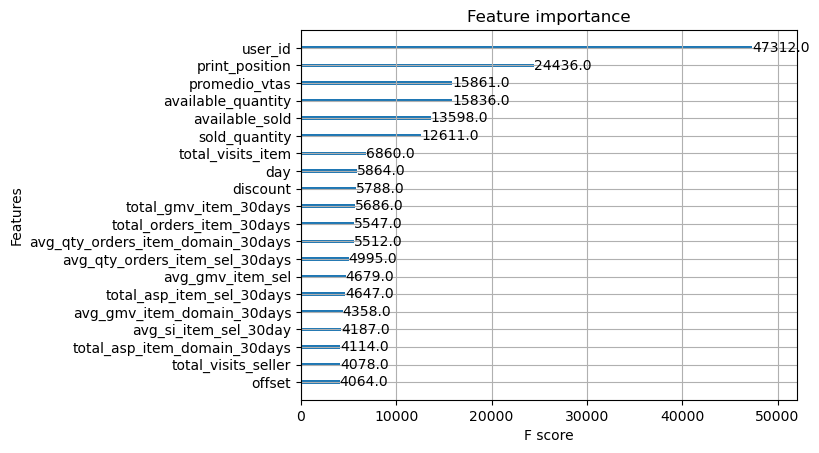

In [44]:
xgb.plot_importance(clf_xgb2, max_num_features=20)
plt.show()